# Run ISC

This script runs ISC

## py conversion

In [38]:
#jupyter nbconvert --to python slurm_create-data_preproc.ipynb

## Imports 

In [39]:
import warnings
import sys  
import random
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
import nilearn as nil
# Import a function from BrainIAK to simulate fMRI data
import brainiak.utils.fmrisim as sim  

from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 



from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from nilearn import datasets, plotting
from nilearn.input_data import NiftiSpheresMasker

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img

from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img

import numpy as np 
import os
import os.path
import scipy.io
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from copy import deepcopy

# Brainiak # 
from brainiak import image, io 
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_stat_map
%matplotlib inline

In [40]:
random.seed(10)

## custom helper functions 

## directories 

In [41]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


## main vars 

In [42]:
### sub_list ###
"""

========================================================
===== ~~~ Summary ALL ~~~ ===== 
========================================================
Initially exclude: sub-001, sub-003, sub-011, sub-012, sub-014, sub-015, sub-029 (3+ runs still available tho)
Maybe exclude: sub-014, sub-024, sub-037 (No button presses)
Maybe exclude: sub-020, sub-022, sub-031
total exclude = 10


~~~~~~~ BEHAVIORAL ~~~~~~~~~~
~~~ Summary behavioral ~~~

========================================================
========================================================
No button presses: sub-014, sub-024, sub-037 

========================================================
========================================================
sub-003: Extra row observed for external, which was manually deleted. Should be fine to rerun -- i removed from bad_subs
    - current brushing: 87, TRUE: 88 for THREE runs. last run when there was an issue and scan had to be restarted
    - Scan 6 == 1 run of brushing
    - Scan 7 = 3 runs of brushing 
    - ** no idea when run 7 was started tho! will prolly need to throw out! For now we can process all
sub-014: NO internal OR external bpress, curious! ---should be fixed now
    - changed excel data to include two null columns
    - ALSO only 30 TRs for the second run epi data. i went into the room to adjust runny eyes. Data for this run is not usable. but after should
      be okay if u want to put in the effort 
sub-015: less than 24 runs ---should be fixed now w custom code (but keep out of main run cuz will throw an error otherwise )
    - SUMMARY: need to exclude the office run 3 for fMRI but can include run 3 in behavioral, no data at all for CAKE
    - DID NOT add the 'mov_name' component to the custom code, will need to implment from current iteration
    - **** Use external, ignore internal for now... cuz internal is fuqd. Can preprocess all 7 tho

~~~~~~~ FMRI ~~~~~~~~~~
~~~ Summary fMRI ~~~
sub002: 
 - appended two TRs onto the last run, copied from the third to last TR. should be good to use
sub-003, sub-012, sub-014, sub-015, sub-029: 
 - Five runs usable, will need to incorporate them at some point 
sub-001: external usable - first three runs 

========================================================
========================================================
subject 002: (usable, with adjustment)
    only has 92 INSTEAD OF 94 TRs for the FINAL run of shrek. i think cuz i turned off the scanner
    too soon, which didn't account for 4 TRs of buffer? Yep! end tr is 390, (388, 112179). so duplicate TRs maybe.
    - Temporarily eliminate! or duplicate TRs 
    
sub-003: (usable, 5 runs)
- Scan 6 == 1 run of brushing
- Scan 7 = 3 runs of brushing 
*** need to re-preprocess, then append 6 and 7 together; or just throw out this one cuz idk when scan started

sub-011: (usable)
- not preprocessed 
sub-012 (5 runs usable, one run idk)
- I'll need to post process. It seems that an earbud fell out while reading the directions for run 5 
summary: the fifth run  needs to be discarded. all others are usable.
see the behav data: 
sub_dic['External']['oragami']
{'run-1': {'start_tr': 94, 'end_tr': 188, 'bpress': -1},
 'run-2': {'start_tr': 188, 'end_tr': 282, 'bpress': [100.81657150003593]},
 'run-3': {'start_tr': 282, 'end_tr': 376, 'bpress': [88.26579949003644]},
 'run-4': {'start_tr': 378,
  'end_tr': 472,
  }
- you can see taht the start TR is 94!! that's becuz i had to go into the scan room during the instructions screen.
- this is producing the wrong indexing -- becuz the scan doesn't contain enough TRs according to the behavioral data:
    - run 4 of shrek only has 12 TRs because we start at TR 94.
- im not sure when the scan actually started, but if i wanted to try to include i could 
    set the start TR to 1 -- essentially suggesting that the first TR was collected on the external 'waiting 
    for TR' flip. might as well try at some point, but exclude for now
    - this would involve just subtracting 94 from all start end end TRs i think
See the excel behavioral file for further notes notes
this 

sub-014 - no button press data and 7 runs (5 runs usable, but no bpress)
    - same problem as above -- i went into the scanner room during the instructions period to wipe eyes
    {'run-1': {'start_tr': 237, 'end_tr': 323, 'bpress': -1},
     'run-2': {'start_tr': 329, 'end_tr': 415, 'bpress': -1},
     'run-3': {'start_tr': 417, 'end_tr': 503, 'bpress': -1},
     'run-4': {'start_tr': 509, 'end_tr': 595, 'bpress': -1}}

sub-029: (5 runs usable)
- scanner malfunction, maybe possible to stitch together run 6 cuz i started on the *tenth* TR

========================================================
========================================================
Left handed: (sub-020, sub-022, sub-032)
    - sub-020: also no button presses, appeared to be awake tho
    - sub-022: lefty
    - sub-031: ambidexterious, great data
========================================================
========================================================
"""

## adjusted sublist 
sub_list = [
    'sub-002', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010',
    'sub-013','sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028','sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040'
]
#sub_list = ['sub-002', 'sub-003', 'sub-004', 'sub-005']

###### LOADING VARS #######




In [7]:
## TR length of each movie ## 
mov_len_dic = {
'oragami' :  82,
'shrek' : 90,
'sherlock' : 98,
'brushing' : 88,
'cake' : 99,
'office' : 102    
}

voxel_num = 112179

In [8]:
## how many TRs on the end? ## 
tr_buffer = 4 

## how many TRs at the beginning to trim? ## 


In [ ]:
external = {}
internal = {}

for sub in sub_list:
    ### fMRI load ###
    sub_dic_fmri = np.load(f'{preproc_dir}/{sub}_fwhm6_conf.npy', allow_pickle=True).item()
    print(f'start {sub}')
    ## BEHAVIORAL ##
    sub_dic_behav = np.load(os.path.join(behav_dir, f'{sub}_behav.npy'), allow_pickle=True).item()

    # Initialize an empty dictionary to store the stacked arrays for the current subject
    stacked_arrays = {}
    
    # Create subject number 
    sub_num = int(sub[-3:])

    for epi_index in range(0, 6):
        # Add one to the index to create 1-6 runs
        epi_run = epi_index + 1

        # Get the movie name
        mov_name = sub_dic_behav['mov_order'][epi_index]

        # Create an empty array for the movie runs
        mov_runs = np.zeros((mov_len_dic[mov_name] + tr_buffer, voxel_num, 0))

        print(f'movie: {mov_name} with shape {mov_runs.shape}')

        # Get the fMRI run for the current epi_index
        fmri_run = sub_dic_fmri[epi_run]
        
        # Loop over runs
        for run in range(1, 5):
            # Is this an internal or external run?
            key = 'External' if (sub_num % 2 == 1 and epi_index < 3) or (sub_num % 2 == 0 and epi_index >= 3) else 'Internal'
            
            # Begin slicing #
            start_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['start_tr']
            end_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['end_tr']
            run_slice = fmri_run[start_tr:end_tr, :]
            
            # BEHAV checks #
            assert mov_runs.shape[0] == mov_len_dic[mov_name] + tr_buffer, f'behavioral ERROR: movie: {mov_name}, epi {epi_run}, run: {run}'

            # fMRI data check #
            assert run_slice.shape[0] == mov_runs.shape[0], f'fMRI error! {run_slice.shape[0]} verse {mov_runs.shape[0]}'
        
            # Stack the run slice with the mov_runs array
            mov_runs = np.dstack((mov_runs, run_slice))
            print(f'stacked! {mov_runs.shape}')

        # Add an additional dimension for subject stacking
        #mov_runs = np.expand_dims(mov_runs, 3)
        
        # Stack the mov_runs array with the external[mov_name] array
        #stacked_arrays[mov_name] = mov_runs
        
        # set outer loop #
        if key == 'External':
            target_dict = external
        else:
            target_dict = internal

        if mov_name not in target_dict:
            target_dict[mov_name] = mov_runs
        else:
            #mov_runs = np.expand_dims(mov_runs, 3)
            target_dict[mov_name] = np.dstack((target_dict[mov_name], mov_runs))
    print(f'\n subject {sub} finished \n')

            
print('done')
            
            
            
            
            
            

start sub-002
movie: shrek with shape (94, 112179, 0)
stacked! (94, 112179, 1)
stacked! (94, 112179, 2)
stacked! (94, 112179, 3)
stacked! (94, 112179, 4)
movie: sherlock with shape (102, 112179, 0)
stacked! (102, 112179, 1)
stacked! (102, 112179, 2)
stacked! (102, 112179, 3)
stacked! (102, 112179, 4)
movie: oragami with shape (86, 112179, 0)
stacked! (86, 112179, 1)
stacked! (86, 112179, 2)
stacked! (86, 112179, 3)
stacked! (86, 112179, 4)
movie: office with shape (106, 112179, 0)
stacked! (106, 112179, 1)
stacked! (106, 112179, 2)
stacked! (106, 112179, 3)
stacked! (106, 112179, 4)
movie: cake with shape (103, 112179, 0)
stacked! (103, 112179, 1)
stacked! (103, 112179, 2)
stacked! (103, 112179, 3)
stacked! (103, 112179, 4)
movie: brushing with shape (92, 112179, 0)
stacked! (92, 112179, 1)
stacked! (92, 112179, 2)
stacked! (92, 112179, 3)
stacked! (92, 112179, 4)

 subject sub-002 finished 

start sub-004
movie: cake with shape (103, 112179, 0)
stacked! (103, 112179, 1)
stacked! (103,

stacked! (103, 112179, 1)
stacked! (103, 112179, 2)
stacked! (103, 112179, 3)
stacked! (103, 112179, 4)
movie: brushing with shape (92, 112179, 0)
stacked! (92, 112179, 1)
stacked! (92, 112179, 2)
stacked! (92, 112179, 3)
stacked! (92, 112179, 4)
movie: office with shape (106, 112179, 0)
stacked! (106, 112179, 1)
stacked! (106, 112179, 2)
stacked! (106, 112179, 3)
stacked! (106, 112179, 4)
movie: shrek with shape (94, 112179, 0)
stacked! (94, 112179, 1)
stacked! (94, 112179, 2)
stacked! (94, 112179, 3)
stacked! (94, 112179, 4)
movie: oragami with shape (86, 112179, 0)
stacked! (86, 112179, 1)
stacked! (86, 112179, 2)
stacked! (86, 112179, 3)
stacked! (86, 112179, 4)
movie: sherlock with shape (102, 112179, 0)
stacked! (102, 112179, 1)
stacked! (102, 112179, 2)
stacked! (102, 112179, 3)
stacked! (102, 112179, 4)

 subject sub-016 finished 

start sub-017
movie: cake with shape (103, 112179, 0)
stacked! (103, 112179, 1)
stacked! (103, 112179, 2)
stacked! (103, 112179, 3)
stacked! (103, 1

stacked! (92, 112179, 3)
stacked! (92, 112179, 4)
movie: cake with shape (103, 112179, 0)
stacked! (103, 112179, 1)
stacked! (103, 112179, 2)
stacked! (103, 112179, 3)
stacked! (103, 112179, 4)
movie: office with shape (106, 112179, 0)
stacked! (106, 112179, 1)
stacked! (106, 112179, 2)
stacked! (106, 112179, 3)
stacked! (106, 112179, 4)
movie: oragami with shape (86, 112179, 0)
stacked! (86, 112179, 1)
stacked! (86, 112179, 2)
stacked! (86, 112179, 3)
stacked! (86, 112179, 4)
movie: sherlock with shape (102, 112179, 0)
stacked! (102, 112179, 1)
stacked! (102, 112179, 2)
stacked! (102, 112179, 3)
stacked! (102, 112179, 4)
movie: shrek with shape (94, 112179, 0)
stacked! (94, 112179, 1)
stacked! (94, 112179, 2)
stacked! (94, 112179, 3)
stacked! (94, 112179, 4)

 subject sub-025 finished 

start sub-026
movie: sherlock with shape (102, 112179, 0)
stacked! (102, 112179, 1)
stacked! (102, 112179, 2)
stacked! (102, 112179, 3)
stacked! (102, 112179, 4)
movie: shrek with shape (94, 112179, 0)

# Reshape Dictionary

In [ ]:
# .transpose(0, 1, 3, 2)

In [ ]:
def reshape_dictionary(data, num_repeats = 4):
    """
    purpose: create a 4d array sorted into x runs per subject
    input: dictionary of stacked subject data 
    output: 4d array sorted into runs
    """
    output_dict = {}
    for mov in data:
        print(f'{mov} size is {data[mov].shape}')
        dim_3 = num_repeats
        dim_4 = int(data[mov].shape[2] / num_repeats)
        
        if key not in output_dict:
            output_dict[mov] = data[mov].reshape(*data[mov].shape[:-1], dim_3, dim_4, order = 'F')
        
        #print(np.array_equal(data[mov][:, :, 1], output_dict[mov][:, :, 0, 1]))
        #print(np.array_equal(data[mov][:, :, 17], output_dict[mov][:, :, 1, 0]))
        print(np.array_equal(data[mov][:, :, 4], output_dict[mov][:, :, 0, 1]))
        print(f'reshaped {output_dict[mov].shape}')
    print()
    return output_dict

    

In [9]:
ext_isc = reshape_dictionary(external)
int_isc = reshape_dictionary(internal)

NameError: name 'reshape_dictionary' is not defined

In [136]:
np.savez_compressed(f'{isc_dir}/ext_isc.npz', **ext_isc)
np.savez_compressed(f'{isc_dir}/int_isc.npz', **int_isc)

KeyboardInterrupt: 

In [10]:
loaded_int_isc = np.load(f'{isc_dir}/int_isc.npz')
loaded_ext_isc = np.load(f'{isc_dir}/ext_isc.npz')

# Access the arrays within the loaded files
#int_isc = loaded_int_isc['arr_0']
#ext_isc = loaded_ext_isc['arr_0']

KeyError: 'arr_0 is not a file in the archive'

<bound method Mapping.keys of <numpy.lib.npyio.NpzFile object at 0x7faea15bdfd0>>

In [13]:
loaded_ext_isc['office']

KeyboardInterrupt: 

# ISC ANAL

In [15]:
run = 3
movie = 'office'


In [16]:
# select movie and run from loaded data 
data = ext_isc[movie][...,run - 1,:]
#data = loaded_int_isc['sherlock'][...,run - 1,:]
print(f'{movie} run {run} shape is: {data.shape}')

# Z-score time series for each voxel
data = zscore(data, axis=0)

office run 3 shape is: (102, 112179, 17)


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [116]:
# Leave-one-out approach
iscs = isc(data, pairwise=False, tolerate_nans=.8)

In [117]:
# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"left-out subjects and {iscs.shape[1]} voxel(s)")

ISC values shape = (17, 112179) 
i.e., 17 left-out subjects and 112179 voxel(s)


In [118]:
# Compute mean ISC (with Fisher transformation)
mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
      f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
      f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")


# Compute median ISC
median_iscs = compute_summary_statistic(iscs, summary_statistic='median',
                                        axis=0)

print(f"ISC values shape = {median_iscs.shape} \ni.e., {median_iscs.shape[0]} "
      f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum median ISC across voxels = {np.nanmin(median_iscs):.3f}; "
      f"maximum median ISC across voxels = {np.nanmax(median_iscs):.3f}")

ISC values shape = (112179,) 
i.e., 112179 mean value across left-out subjects and 112179 voxel(s)
Minimum mean ISC across voxels = -0.152; maximum mean ISC across voxels = 0.746
ISC values shape = (112179,) 
i.e., 112179 median value across left-out subjects and 112179 voxel(s)
Minimum median ISC across voxels = -0.177; maximum median ISC across voxels = 0.787


In [119]:
# Run bootstrap hypothesis test on ISCs
n_boot = 1000
observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median',
                                              n_bootstraps=n_boot)

In [120]:
observed.shape

(112179,)

Before we correct for multiple tests, we should exclude any voxels with NaNs. To do this, we'll extract the non-NaN voxels, run the correction for multiple tests, then reinsert the non-NaN voxels into the full mask.

In [121]:
# Get number of NaN voxels
n_nans = np.sum(np.isnan(observed))
print(f"{n_nans} voxels out of {observed.shape[0]} are NaNs "
      f"({n_nans / observed.shape[0] * 100:.2f}%)")

# Get voxels without NaNs
nonnan_mask = ~np.isnan(observed)
nonnan_coords = np.where(nonnan_mask)

# Mask both the ISC and p-value map to exclude NaNs
nonnan_isc = observed[nonnan_mask]
nonnan_p = p[nonnan_mask]

3635 voxels out of 112179 are NaNs (3.24%)


Now we'll apply the multipletests function from StatsModels to the p-values from the bootstrap hypothesis test to control the false discovery rate (FDR) at 0.05 across all voxels. This yields a map of q-values. We can then threshold our ISC image based on the FDR-adjusted q-values, which are derived from the entire image, rather than the uncorrected p-values.

In [122]:
# Get FDR-controlled q-values
nonnan_q = multipletests(nonnan_p, method='fdr_by')[1]
threshold = .05
print(f"{np.sum(nonnan_q < threshold)} significant voxels "
      f"controlling FDR at {threshold}")

# Threshold ISCs according FDR-controlled threshold
nonnan_isc[nonnan_q >= threshold] = np.nan

# Reinsert thresholded ISCs back into whole brain image
isc_thresh = np.full(observed.shape, np.nan)
isc_thresh[nonnan_coords] = nonnan_isc

0 significant voxels controlling FDR at 0.05


create empty 3d image for visualization

In [123]:
## mask image ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")

# Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

In [124]:
# Create empty 3D image and populate
# with thresholded ISC values
isc_img = np.full(ref_nii.shape, np.nan)
isc_img[mask_coords] = isc_thresh

# Convert to NIfTI image
isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)

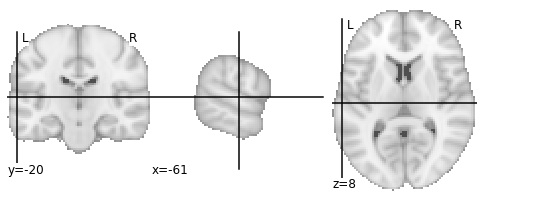

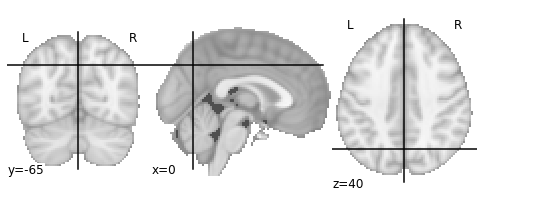

In [125]:
# Plot slices at coordinates -61, -20, 8
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(-61, -20, 8))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(0, -65, 40))
plt.show()

## ALL AT ONCE ## 

### masking

In [11]:
## mask image ##
ref_nii = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
mask_img = load_boolean_mask(mask_dir + "/whole_b_bnk.nii.gz")

# Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

In [12]:
# load if necessary
vis_dic = np.load(f'{isc_dir}/vis_dic.npy', allow_pickle=True).item()

### vars

In [20]:
runs = [1, 2, 3, 4]
conditions = ["Internal", "External"]
mov_list = ['office', 'brushing', 'oragami', 'shrek', 'cake', 'sherlock']
vis_dic = {}

### run

In [ ]:
for cond in conditions:
    print(f'START {cond}')
    if cond == "External":
        targ_dic = ext_isc
    else:
        targ_dic = int_isc
    for run in runs:
        for mov in mov_list:
    
            # select movie and run from loaded data ** account for indexing
            data = targ_dic[mov][...,run - 1,:]
            print(f'{mov} run {run} shape is: {data.shape}')

            # Z-score time series for each voxel
            data = zscore(data, axis=0)

            # Leave-one-out approach
            iscs = isc(data, pairwise=False, tolerate_nans=.8)

            # Check shape of output ISC values
            print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
                  f"left-out subjects and {iscs.shape[1]} voxel(s)")

            # Compute mean ISC (with Fisher transformation)
            mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

            print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
                  f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
                  f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")


            # Compute median ISC
            median_iscs = compute_summary_statistic(iscs, summary_statistic='median',
                                                    axis=0)

            print(f"ISC values shape = {median_iscs.shape} \ni.e., {median_iscs.shape[0]} "
                  f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum median ISC across voxels = {np.nanmin(median_iscs):.3f}; "
                  f"maximum median ISC across voxels = {np.nanmax(median_iscs):.3f}")

            # Run bootstrap hypothesis test on ISCs
            n_boot = 1000
            observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=False,
                                                          ci_percentile=95,
                                                          summary_statistic='median',
                                                          n_bootstraps=n_boot)


            # Get number of NaN voxels
            n_nans = np.sum(np.isnan(observed))
            print(f"{n_nans} voxels out of {observed.shape[0]} are NaNs "
                  f"({n_nans / observed.shape[0] * 100:.2f}%)")

            # Get voxels without NaNs
            nonnan_mask = ~np.isnan(observed)
            nonnan_coords = np.where(nonnan_mask)

            # Mask both the ISC and p-value map to exclude NaNs
            nonnan_isc = observed[nonnan_mask]
            nonnan_p = p[nonnan_mask]

            # Get FDR-controlled q-values
            nonnan_q = multipletests(nonnan_p, method='fdr_by')[1]
            threshold = .05
            print(f"{np.sum(nonnan_q < threshold)} significant voxels "
                  f"controlling FDR at {threshold}")

            # Threshold ISCs according FDR-controlled threshold
            nonnan_isc[nonnan_q >= threshold] = np.nan

            # Reinsert thresholded ISCs back into whole brain image
            isc_thresh = np.full(observed.shape, np.nan)
            isc_thresh[nonnan_coords] = nonnan_isc

            # Create empty 3D image and populate
            # with thresholded ISC values
            isc_img = np.full(ref_nii.shape, np.nan)
            isc_img[mask_coords] = isc_thresh

            # Convert to NIfTI image
            isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)
            
            # Save
            vis_dic[f'{cond}-{mov}-{run}'] = isc_nii
            print(f'\nfinish {cond}-{mov}-{run}\n')
            
            #np.save(f'{isc_dir}/vis_dic.npy', vis_dic)

START Internal
office run 1 shape is: (106, 112179, 16)


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


ISC values shape = (16, 112179) 
i.e., 16 left-out subjects and 112179 voxel(s)
ISC values shape = (112179,) 
i.e., 112179 mean value across left-out subjects and 112179 voxel(s)
Minimum mean ISC across voxels = -0.161; maximum mean ISC across voxels = 0.751
ISC values shape = (112179,) 
i.e., 112179 median value across left-out subjects and 112179 voxel(s)
Minimum median ISC across voxels = -0.160; maximum median ISC across voxels = 0.761


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/brainiak/isc.py:523: RuntimeWarning: Mean of empty slice
  statistic = np.tanh(np.nanmean(np.arctanh(iscs), axis=axis))
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


3327 voxels out of 112179 are NaNs (2.97%)
41090 significant voxels controlling FDR at 0.05

finish Internal-office-1

brushing run 1 shape is: (92, 112179, 16)
ISC values shape = (16, 112179) 
i.e., 16 left-out subjects and 112179 voxel(s)
ISC values shape = (112179,) 
i.e., 112179 mean value across left-out subjects and 112179 voxel(s)
Minimum mean ISC across voxels = -0.175; maximum mean ISC across voxels = 0.536
ISC values shape = (112179,) 
i.e., 112179 median value across left-out subjects and 112179 voxel(s)
Minimum median ISC across voxels = -0.189; maximum median ISC across voxels = 0.600
2650 voxels out of 112179 are NaNs (2.36%)
0 significant voxels controlling FDR at 0.05

finish Internal-brushing-1

oragami run 1 shape is: (86, 112179, 17)
ISC values shape = (17, 112179) 
i.e., 17 left-out subjects and 112179 voxel(s)
ISC values shape = (112179,) 
i.e., 112179 mean value across left-out subjects and 112179 voxel(s)
Minimum mean ISC across voxels = -0.183; maximum mean ISC 

In [18]:
vis_dic

{'Internal-office-1': <nibabel.nifti1.Nifti1Image at 0x7f8d54fcee10>,
 'Internal-brushing-1': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad97310>,
 'Internal-oragami-1': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad97a90>,
 'Internal-shrek-1': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad97b50>,
 'Internal-cake-1': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad97c50>,
 'Internal-sherlock-1': <nibabel.nifti1.Nifti1Image at 0x7f8d89ce2790>,
 'Internal-office-2': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad97d90>,
 'Internal-brushing-2': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad97e50>,
 'Internal-oragami-2': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad97f10>,
 'Internal-shrek-2': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad97fd0>,
 'Internal-cake-2': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad90110>,
 'Internal-sherlock-2': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad901d0>,
 'Internal-office-3': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad90290>,
 'Internal-brushing-3': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad90350>,
 'Internal-ora

# Visualize

In [17]:
# load if necessary
vis_dic = np.load(f'{isc_dir}/vis_dic.npy', allow_pickle=True).item()

In [100]:
isc_nii = vis_dic['Internal-sherlock-1']

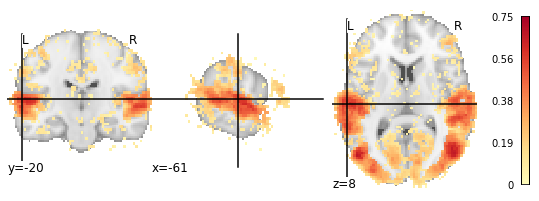

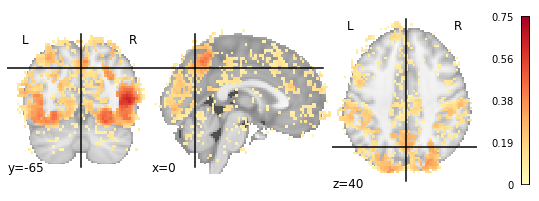

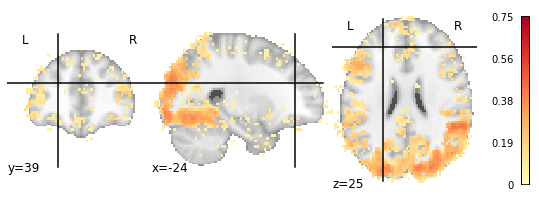

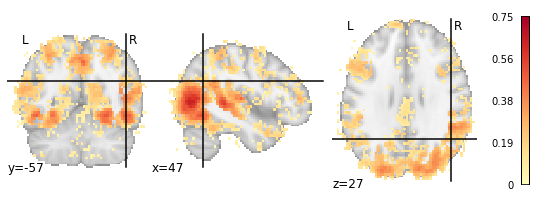

In [103]:
# Plot slices at coordinates -61, -20, 8
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.75,
    cut_coords=(-61, -20, 8))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.75,
    cut_coords=(0, -65, 40))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.75,
    cut_coords=(-24, 39, 25))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.75,
    cut_coords=(47, -57, 27))

plt.show()

In [18]:
isc_nii = vis_dic['External-brushing-1']

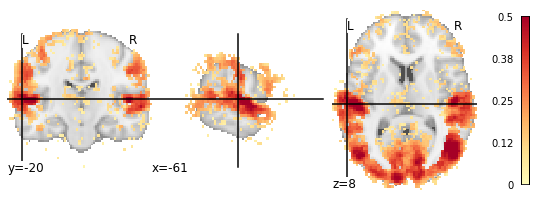

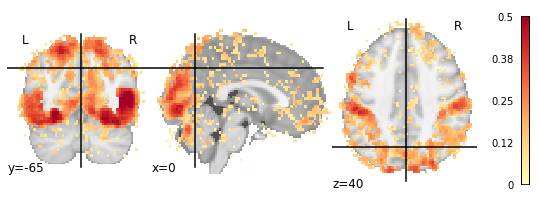

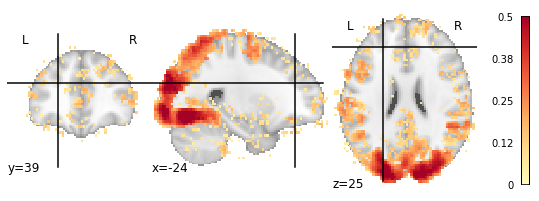

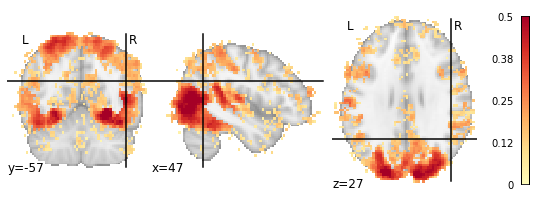

In [19]:
# Plot slices at coordinates -61, -20, 8
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(-61, -20, 8))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(0, -65, 40))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(-24, 39, 25))

# Plot slices at coordinates 0, -65, 40
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(47, -57, 27))

plt.show()

## plot by network

### rerun ISC to get raw correlations, not q values

In [20]:
from utils_anal import load_epi_data

In [23]:
## here we just remove the portion of the code that threshholds 
runs = [1, 2, 3, 4]
conditions = ["Internal", "External"]
mov_list = ['office', 'brushing', 'oragami', 'shrek', 'cake', 'sherlock']
mov_list = [ 'sherlock']
num_parc = 400
vis_dic = {}

In [24]:
cor_dic = {}

In [33]:
net_lab

'R ContC'

In [34]:
targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

In [35]:
targ_net

array([351, 352, 353, 354, 355, 356, 357])

In [37]:
for net_lab in network_labels:
    targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
    print(targ_net)

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[13 14 15 16 17 18 19 20 21 22 23 24]
[25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
[44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
[60 61 62 63 64 65 66 67 68 69 70 71 72]
[73 74 75 76 77 78 79 80 81 82 83 84 85]
[ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100]
[101 102 103 104 105 106 107 108]
[109 110 111 112 113]
[114 115 116 117 118 119 120]
[121 122 123 124 125 126 127 128 129 130 131 132 133]
[134 135 136 137 138 139 140 141 142 143]
[144 145 146 147 148]
[149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166]
[167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187]
[188 189 190 191 192 193 194]
[195 196 197 198 199 200]
[201 202 203 204 205 206 207 208 209 210 211 212]
[213 214 215 216 217 218 219 220 221 222 223]
[224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243]
[244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
[259 260 

In [25]:
num_parc = 400

# Get labels for parcels in left DMN A network
net_lab = 'R ContC' #'L DefaultB'  #'R ContC' #R DorsAttnB  #R VisPeri  #R SalVentAttnA #'R TempPar' #'L SomMotA'

## Target Conditions
targ_cond = "External"

## movie repetitions ##
#m_reps = 1
targ_run = 1

## Get labels associated with the target network ## 
targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

NameError: name 'networks' is not defined

In [29]:
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc)
atlas_filename = dataset.maps
labels = dataset.labels

print(f"Atlas ROIs are located in nifti image (4D) at: {atlas_filename}")

Atlas ROIs are located in nifti image (4D) at: /usr/people/isaacrc/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


In [30]:
# Load  sample data for resampling
resamp_run = load_epi_data(fmri_prep, 'sub-007', 2, "MNI")
# Load parcellation
d = nib.load(atlas_filename)
atlas_nii = resample_to_img(d, resamp_run, interpolation='nearest')
# Get parcellation fdata
atlas_img = atlas_nii.get_fdata()
# paracellations scheme
print(f'count parc:{len(np.unique(atlas_nii.get_fdata()))}')
print("shape of atlas nii object", atlas_img.shape)



Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)


In [27]:
# Load in network labels
label_fn = 'brainiak-aperture-isc-data/Schaefer2018_400Parcels_17Networks_order.txt'
with open(label_fn) as f:
    networks = [' '.join((label.split('_')[1][0], label.split('_')[2]))
                for label in f.readlines()]
    
# Get sorted unique network labels
idxs = np.unique(networks, return_index=True)[1]
network_labels = [networks[idx] for idx in sorted(idxs)]

# Get middle index for each network for plotting
network_idxs = [int(np.median([i for i, n in enumerate(networks)
                                if n == network]))
                for network in network_labels]

In [29]:
# load if necessary
#vis_dic = np.load(f'{isc_dir}/vis_dic_nothresh.npy', allow_pickle=True).item()
vis_dic

{'Internal-office-1': <nibabel.nifti1.Nifti1Image at 0x7f8d9347ca50>,
 'Internal-brushing-1': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a7fd0>,
 'Internal-oragami-1': <nibabel.nifti1.Nifti1Image at 0x7f8d0ad915d0>,
 'Internal-shrek-1': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a8bd0>,
 'Internal-cake-1': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a8b90>,
 'Internal-sherlock-1': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a8a10>,
 'Internal-office-2': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a8950>,
 'Internal-brushing-2': <nibabel.nifti1.Nifti1Image at 0x7f8d89cd8890>,
 'Internal-oragami-2': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a88d0>,
 'Internal-shrek-2': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a8810>,
 'Internal-cake-2': <nibabel.nifti1.Nifti1Image at 0x7f8d89cd88d0>,
 'Internal-sherlock-2': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a8690>,
 'Internal-office-3': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a8510>,
 'Internal-brushing-3': <nibabel.nifti1.Nifti1Image at 0x7f8d4b5a8450>,
 'Internal-ora

In [31]:
bpress_nii = vis_dic['Internal-office-1']

In [71]:
for cond in conditions:
    print(f'START {cond}')
    if cond == "External":
        targ_dic = ext_isc
    else:
        targ_dic = int_isc
    for run in runs:
        for mov in mov_list:
    
            # select movie and run from loaded data ** account for indexing
            data = targ_dic[mov][...,run - 1,:]
            print(f'{mov} run {run} shape is: {data.shape}')

            # Z-score time series for each voxel
            data = zscore(data, axis=0)

            # Leave-one-out approach
            iscs = isc(data, pairwise=False, tolerate_nans=.8)

            # Check shape of output ISC values
            print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
                  f"left-out subjects and {iscs.shape[1]} voxel(s)")

            # Compute mean ISC (with Fisher transformation)
            mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

            print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
                  f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
                  f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")


            # Compute median ISC
            median_iscs = compute_summary_statistic(iscs, summary_statistic='median',
                                                    axis=0)

            print(f"ISC values shape = {median_iscs.shape} \ni.e., {median_iscs.shape[0]} "
                  f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
                  f"\nMinimum median ISC across voxels = {np.nanmin(median_iscs):.3f}; "
                  f"maximum median ISC across voxels = {np.nanmax(median_iscs):.3f}")

            # Run bootstrap hypothesis test on ISCs
            n_boot = 1000
            observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=False,
                                                          ci_percentile=95,
                                                          summary_statistic='median',
                                                          n_bootstraps=n_boot)


            # Get number of NaN voxels
            n_nans = np.sum(np.isnan(observed))
            print(f"{n_nans} voxels out of {observed.shape[0]} are NaNs "
                  f"({n_nans / observed.shape[0] * 100:.2f}%)")

            # Get voxels without NaNs
            nonnan_mask = ~np.isnan(observed)
            nonnan_coords = np.where(nonnan_mask)

            # Mask both the ISC and p-value map to exclude NaNs
            nonnan_isc = observed[nonnan_mask]
            nonnan_p = p[nonnan_mask]

            # Get FDR-controlled q-values
            nonnan_q = multipletests(nonnan_p, method='fdr_by')[1]
            threshold = .05
            print(f"{np.sum(nonnan_q < threshold)} significant voxels "
                  f"controlling FDR at {threshold}")

            # Threshold ISCs according FDR-controlled threshold
            #nonnan_isc[nonnan_q >= threshold] = np.nan

            # Reinsert thresholded ISCs back into whole brain image
            isc_thresh = np.full(observed.shape, np.nan)
            isc_thresh[nonnan_coords] = nonnan_isc

            # Create empty 3D image and populate
            # with thresholded ISC values
            isc_img = np.full(ref_nii.shape, np.nan)
            isc_img[mask_coords] = isc_thresh

            # Convert to NIfTI image
            isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)
            
            # Save
            vis_dic[f'{cond}-{mov}-{run}'] = isc_nii
            print(f'\nfinish {cond}-{mov}-{run}\n')
            
            np.save(f'{isc_dir}/vis_dic_nothresh.npy', vis_dic)
            
            # DO rois # 
            # Convert to 4d numpy array
            f_dat_4d = bpress_nii.get_fdata()

            #targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1
            
            for net in np.array(networks):
                targ_net = net.nonzero()[0] + 1
            
                for parcel in targ_net:
                    if f'{cond}-{mov}-{parcel}' not in cor_dic:
                        cor_dic[f'{cond}-{mov}-{parcel}'] = np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])])
                    else:
                        cor_dic[f'{cond}-{mov}-{parcel}'].append(np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]))
            

START Internal
office run 1 shape is: (106, 112179, 16)


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


ISC values shape = (16, 112179) 
i.e., 16 left-out subjects and 112179 voxel(s)
ISC values shape = (112179,) 
i.e., 112179 mean value across left-out subjects and 112179 voxel(s)
Minimum mean ISC across voxels = -0.161; maximum mean ISC across voxels = 0.751


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/brainiak/isc.py:523: RuntimeWarning: Mean of empty slice
  statistic = np.tanh(np.nanmean(np.arctanh(iscs), axis=axis))
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


ISC values shape = (112179,) 
i.e., 112179 median value across left-out subjects and 112179 voxel(s)
Minimum median ISC across voxels = -0.160; maximum median ISC across voxels = 0.761
3327 voxels out of 112179 are NaNs (2.97%)
41732 significant voxels controlling FDR at 0.05

finish Internal-office-1



NameError: name 'cor_dic' is not defined

In [86]:
cor_dic = {}

In [87]:
# DO rois # 
# Convert to 4d numpy array
f_dat_4d = bpress_nii.get_fdata()

targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]
if f'{cond}-{mov}-{net_lab}' not in cor_dic:
    cor_dic[f'{cond}-{mov}-{net_lab}'] = [np.nanmean(temp)]
else:
    cor_dic[f'{cond}-{mov}-{net_lab}'].append(np.nanmean(temp))

In [88]:
cor_dic

{'Internal-office-R ContC': [0.16539153784835273]}

In [77]:
temp = [np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]) for parcel in targ_net]


In [78]:
temp

[0.15212171162661273,
 0.12460714368962275,
 0.17385008319929765,
 0.15132106836969056,
 0.13594276718869874,
 0.17802443846383664,
 0.24187355240071007]

In [41]:
# Convert to 4d numpy array
f_dat_4d = bpress_nii.get_fdata()

targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

# loop through all TRs and get the target voxel pattern #
bpress_pat = np.column_stack([f_dat_4d[atlas_img == parcel].T
                for parcel in targ_net])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 162 and the array at index 1 has size 215

In [37]:
atlas_img.shape

(78, 93, 65)

In [47]:
np.nanmean(f_dat_4d[atlas_img == parcel])

0.24187355240071007

In [42]:
for parcel in targ_net:
    np.column_stack(f_dat_4d[atlas_img == parcel])
    print(parcel)

351
352
353
354
355
356
357


In [52]:
reg_cor = np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])
                for parcel in targ_net])

In [ ]:
cor_dic = {}
runz = [1, 2, 3, 4]


for parcel in targ_net:
    if parcel not in cor_dic:
        cor_dic[parcel] = np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])])
    else:
        cor_dic[parcel].append(np.nanmean([np.nanmean(f_dat_4d[atlas_img == parcel])]))
                        

In [53]:
bpress_pat

0.16539153784835273

In [ ]:
f_dat_4d[]